In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Layer, Bidirectional, Attention
from keras import optimizers 
from sklearn.metrics import mean_squared_error

seed = 1234
np.random.seed(seed)
plt.style.use('ggplot')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
data_raw = pd.read_csv("VNM.csv", index_col="Date", parse_dates=["Date"])
data_raw = data_raw.dropna()

 Count row of data:  988


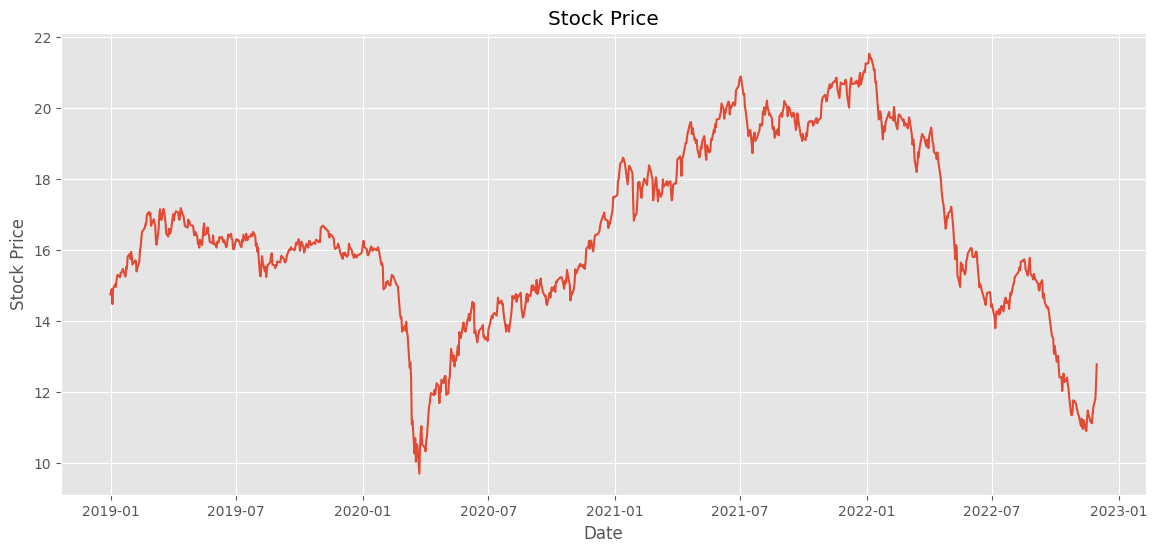

In [3]:
dataset = pd.DataFrame(data_raw['Close'])
print(' Count row of data: ',len(dataset))

fig = plt.figure(figsize=(14, 6))
plt.plot(dataset)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.title('Stock Price')
plt.show()

In [4]:
dataset_norm = dataset.copy()
dataset[['Close']]
scaler = MinMaxScaler()
dataset_norm['Close'] = scaler.fit_transform(dataset[['Close']])
dataset_norm

,Close
Date,
2018-12-31,0.426881
2019-01-02,0.439560
2019-01-03,0.404057
2019-01-04,0.440406
2019-01-07,0.451395
...,...
2022-11-23,0.120034
2022-11-25,0.158073
2022-11-28,0.177515


In [19]:
totaldata = dataset.values
totaldatatrain = int(len(totaldata)*0.75)
totaldataval = int(len(totaldata)*0.1)
totaldatatest = int(len(totaldata)*0.15)

# Store data into each partition
training_set = dataset_norm[0:totaldatatrain]
val_set=dataset_norm[totaldatatrain:totaldatatrain+totaldataval]
test_set = dataset_norm[totaldatatrain+totaldataval:]

In [20]:
# Initiaton value of lag
lag = 2
# sliding windows function
def create_sliding_windows(data,len_data,lag):
    x=[]
    y=[]
    for i in range(lag,len_data):
        x.append(data[i-lag:i,0])
        y.append(data[i,0]) 
    return np.array(x),np.array(y)

# Formating data into array for create sliding windows
array_training_set = np.array(training_set)
array_val_set = np.array(val_set)
array_test_set = np.array(test_set)

# Create sliding windows into training data
x_train, y_train = create_sliding_windows(array_training_set,len(array_training_set), lag)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
# Create sliding windows into validation data
x_val,y_val = create_sliding_windows(array_val_set,len(array_val_set),lag)
x_val = np.reshape(x_val, (x_val.shape[0],x_val.shape[1],1))
# Create sliding windows into test data
x_test,y_test = create_sliding_windows(array_test_set,len(array_test_set),lag)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [21]:
# Hyperparameters
learning_rate = 0.0001
hidden_unit = 64
batch_size=64
epoch = 100

# Architecture Gated Recurrent Unit
model = Sequential()

# First GRU layer with dropout
model.add(Bidirectional(LSTM(units=hidden_unit, return_sequences=True, input_shape=(x_train.shape[1],1), activation = 'relu')))
model.add(Dropout(0.2))
# Second GRU layer with dropout
model.add(Bidirectional(LSTM(units=hidden_unit, return_sequences=True, activation = 'relu')))
model.add(Dropout(0.2))
# Third GRU layer with dropout
model.add(Bidirectional(LSTM(units=hidden_unit, return_sequences=False, activation = 'relu')))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))

# Compiling the Gated Recurrent Unit
model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),loss='mean_squared_error')

# Fitting ke data training dan data validation
pred = model.fit(x_train, y_train, validation_data=(x_val,y_val), batch_size=batch_size, epochs=epoch)

Epoch 1/100
12/12 [==============================] - 8s 78ms/step - loss: 0.3242 - val_loss: 0.5151
Epoch 2/100
12/12 [==============================] - 0s 16ms/step - loss: 0.1615 - val_loss: 0.1053
Epoch 3/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0311 - val_loss: 0.0032
Epoch 4/100
12/12 [==============================] - 0s 12ms/step - loss: 0.0185 - val_loss: 0.0484
Epoch 5/100
12/12 [==============================] - 0s 11ms/step - loss: 0.0151 - val_loss: 0.0071
Epoch 6/100
12/12 [==============================] - 0s 11ms/step - loss: 0.0118 - val_loss: 0.0155
Epoch 7/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0099 - val_loss: 0.0035
Epoch 8/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0070 - val_loss: 0.0036
Epoch 9/100
12/12 [==============================] - 0s 19ms/step - loss: 0.0051 - val_loss: 6.0298e-04
Epoch 10/100
12/12 [==============================] - 0s 15ms/step - loss: 0.0040 - val_loss: 9.

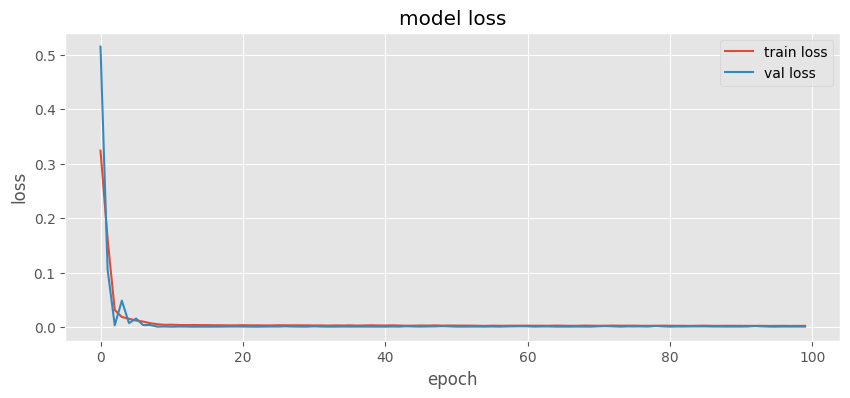

In [22]:
fig = plt.figure(figsize=(10, 4))
plt.plot(pred.history['loss'], label='train loss')
plt.plot(pred.history['val_loss'], label='val loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

In [23]:
learningrate_parameter = learning_rate
train_loss=pred.history['loss'][-1]
validation_loss=pred.history['val_loss'][-1]
learningrate_parameter=pd.DataFrame(data=[[learningrate_parameter, train_loss, validation_loss]],
                                    columns=['Learning Rate', 'Training Loss', 'Validation Loss'])
learningrate_parameter.set_index('Learning Rate')

,Training Loss,Validation Loss
Learning Rate,,
0.0001,0.002097,0.000749


In [24]:
y_pred_test = model.predict(x_test)

# Invert normalization min-max
y_pred_invert_norm = scaler.inverse_transform(y_pred_test)

5/5 [==============================] - 1s 4ms/step


In [25]:
set_test = dataset["Close"]

In [26]:
datacompare = pd.DataFrame()
datatest=np.array(set_test[totaldatatrain+totaldataval+lag:])
datapred= y_pred_invert_norm

datacompare['Data Test'] = datatest
datacompare['Prediction Results'] = datapred
datacompare

,Data Test,Prediction Results
0,17.219999,17.010592
1,17.059999,17.104795
2,16.860001,17.069622
3,16.620001,16.885792
4,15.740000,16.662764
...,...,...
142,11.120000,10.905536
143,11.570000,10.884079
144,11.800000,11.092619
145,12.200000,11.515539


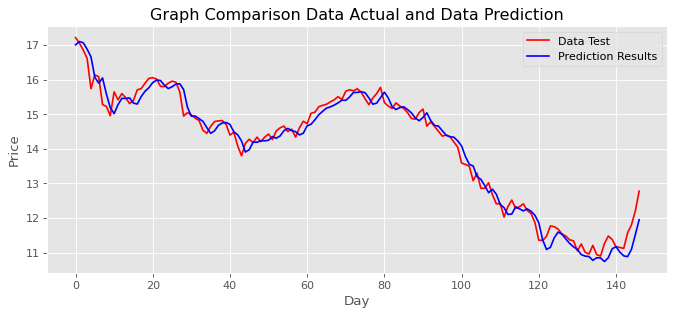

In [27]:
plt.figure(num=None, figsize=(10, 4), dpi=80,facecolor='w', edgecolor='k')
plt.title('Graph Comparison Data Actual and Data Prediction')
plt.plot(datacompare['Data Test'], color='red',label='Data Test')
plt.plot(datacompare['Prediction Results'], color='blue',label='Prediction Results')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()

In [28]:
def MAPE(datatest,datapred):
    mape = np.mean(np.abs((datatest - datapred)/datatest))*100
    return mape

mape = MAPE(datatest, datapred)
print(mape)

13.738295078642611


In [29]:
from sklearn.metrics import mean_squared_error
import math
MSE = mean_squared_error(datatest, datapred)
RMSE = math.sqrt(MSE)
print(RMSE)

0.2761624981131313


In [30]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(
    y_true=datatest,
    y_pred=datapred
)

0.2076929376191639

In [32]:
n_ahead=input("How many values do you want to predict ?");
n_ahead=int(n_ahead)
# Making the prediction list 
def predict_ahead(n_ahead, X_train):
   yhat = []
   for _ in range(n_ahead):
   # Making the prediction
       fc = model.predict(X_train)
       yhat.append(fc)

   # Creating a new input matrix for forecasting
       X_train = np.append(X_train, fc)

   # Ommitting the first variable
       X_train = np.delete(X_train, 0)

   # Reshaping for the next iteration
       X_train = np.reshape(X_train, (1, len(X_train), 1))

   return yhat 
y30 = predict_ahead(n_ahead, x_test[len(x_test)-30:])

1/1 [==============================] - 0s 38ms/step


In [33]:
y30

[array([[0.21674204],
        [0.21097781],
        [0.20105417],
        [0.18288219],
        [0.14114706],
        [0.11761088],
        [0.12266176],
        [0.14602378],
        [0.16010551],
        [0.15469024],
        [0.14323843],
        [0.13223785],
        [0.12397379],
        [0.11763855],
        [0.1049497 ],
        [0.1013751 ],
        [0.1002242 ],
        [0.0910664 ],
        [0.09719525],
        [0.09686133],
        [0.08795277],
        [0.09734835],
        [0.11907981],
        [0.12442023],
        [0.11102837],
        [0.10190491],
        [0.10009122],
        [0.11771923],
        [0.15346901],
        [0.19031721]], dtype=float32),
 array([[7.3751546e+19]], dtype=float32),
 array([[nan]], dtype=float32),
 array([[nan]], dtype=float32),
 array([[nan]], dtype=float32),
 array([[nan]], dtype=float32),
 array([[nan]], dtype=float32),
 array([[nan]], dtype=float32),
 array([[nan]], dtype=float32),
 array([[nan]], dtype=float32),
 array([[nan]], dtype=flo

In [34]:
y30 = [[0.21674204],
        [0.21097781],
        [0.20105417],
        [0.18288219],
        [0.14114706],
        [0.11761088],
        [0.12266176],
        [0.14602378],
        [0.16010551],
        [0.15469024],
        [0.14323843],
        [0.13223785],
        [0.12397379],
        [0.11763855],
        [0.1049497 ],
        [0.1013751 ],
        [0.1002242 ],
        [0.0910664 ],
        [0.09719525],
        [0.09686133],
        [0.08795277],
        [0.09734835],
        [0.11907981],
        [0.12442023],
        [0.11102837],
        [0.10190491],
        [0.10009122],
        [0.11771923],
        [0.15346901],
        [0.19031721]]

In [35]:
y30 = scaler.inverse_transform(y30)

In [37]:
from numpy import savetxt
savetxt('Bi-LSTM.csv', y30, delimiter=',')

In [38]:
data30 = pd.read_csv("B-LSTM.csv")
data30 = data30.dropna()
type(data30)

pandas.core.frame.DataFrame

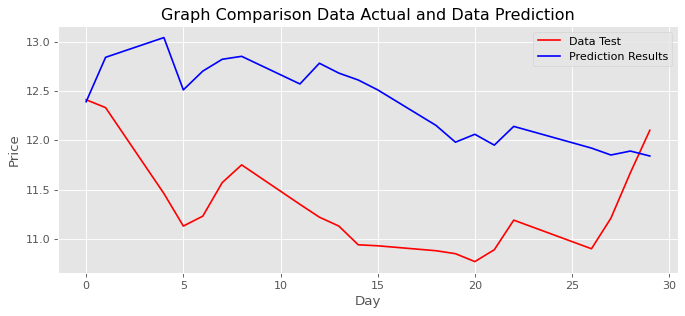

In [47]:
plt.figure(num=None, figsize=(10, 4), dpi=80,facecolor='w', edgecolor='k')
plt.title('Graph Comparison Data Actual and Data Prediction')
plt.plot(data30['predicted'], color='red',label='Data Test')
plt.plot(data30['actual'], color='blue',label='Prediction Results')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()